# Generic LA tool

In [91]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from src.dlla.hw import dlla_p_gradient, prepare_traces_dl
from src.dlla.model9 import make_model_9
from src.dlla.wegener import make_mlp_wegener, wegener_p_gradient
from src.pollution.tools import file_suffix
from src.tools.lists import randomize
from src.tools.plotter import init_plots, plot_p_gradient, PALETTE_GRADIENT, store_sns, TVLA_PALETTE, DLLA_PALETTE
from src.trace_set.database import Database
from src.trace_set.set_hw import TraceSetHW
from src.tvla.cri import tvla_cri
from src.tvla.tvla import prepare_tvla

init_plots()

In [92]:
from src.trace_set.transform import reduce_fixed_fixed

DB = Database.ascad_none

TRACE_SET = TraceSetHW(DB)

POLLUTION_TYPE = None
FILE_SUFFIX = file_suffix(POLLUTION_TYPE, 0)

NUM_CLASSES = 9

In [93]:
PROF_X, PROF_Y = TRACE_SET.profile()

In [94]:
PVS_CRI_ALL = tvla_cri(*prepare_tvla(PROF_X, PROF_Y), max_order=2, progress=False)

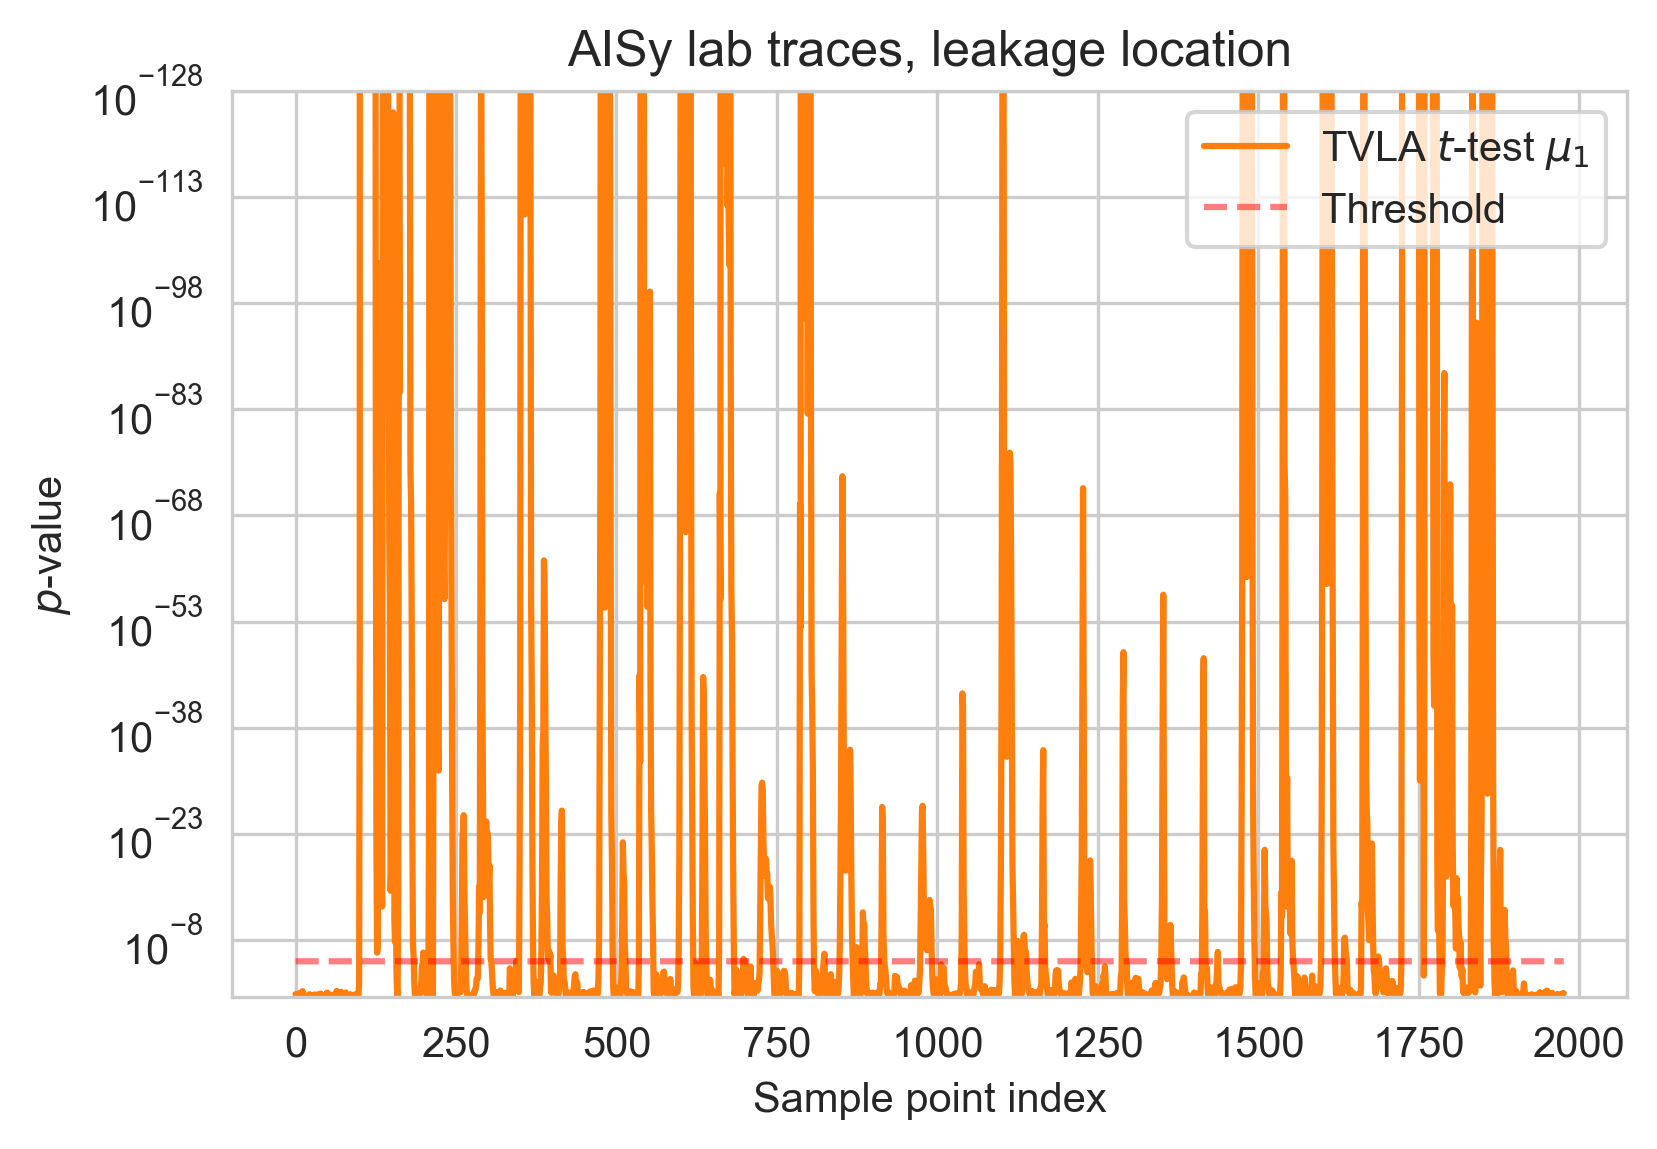

In [95]:
ORDER = 1

G = sns.lineplot(data={"TVLA $t$-test $\mu_1$": PVS_CRI_ALL[ORDER]}, palette=[TVLA_PALETTE[-1]])
sns.lineplot(data= [10 ** -5] * len(PVS_CRI_ALL[ORDER]), color="#FF000080", linestyle="--", label="Threshold")
G.invert_yaxis()
G.set(yscale="log", ylabel="$p$-value", xlabel="Sample point index", title="AISy lab traces, leakage location", ylim=(10 ** 0, 10 ** -128))
store_sns(G, f"{DB.name}-pvs-{FILE_SUFFIX}")

In [96]:
WINDOW = (1150, 1450)

PROF_X = PROF_X[:, WINDOW[0]:WINDOW[1]]
PVS_CRI = PVS_CRI_ALL[:, WINDOW[0]: WINDOW[1]]

np.min(PVS_CRI)

1.4179981288371914e-72

In [97]:
WINDOW_SIZE = WINDOW[1] - WINDOW[0]
TITLE_SUB = f"Unprotected ASCAD traces with {WINDOW_SIZE} sample points"

In [98]:
def single_cri_p_gradient(x, y, min_pvs, order, trace_limit):
    _, min_sp = np.unravel_index(min_pvs.argmin(), min_pvs.shape)

    if trace_limit is not None:
        num_traces = min(len(x), trace_limit)
    else:
        num_traces = len(x)

    num_points = 300
    start = 2

    x_lim = np.array(x[:, min_sp:min_sp + 1])

    pvs = np.ones(num_points)

    point_ixs = np.linspace(start, num_traces, num_points).astype(int)

    for ix, limit in enumerate(point_ixs):
        pvs[ix] = np.min(tvla_cri(x_lim[:limit], y[:limit], max_order=order)[order])

    return np.interp(np.arange(num_traces), point_ixs, pvs)

def cri_p_gradient(x, y, min_pvs, order, times=20, trace_limit=None):
    res = []
    for _ in tqdm(range(times), "CRI p-gradient"):
        res.append(single_cri_p_gradient(*prepare_tvla(x, y), min_pvs, order, trace_limit))

    return np.mean(res, axis=0)

MAX_TRACE_SIZE = 50000

CRI_PG_1 = cri_p_gradient(PROF_X, PROF_Y, PVS_CRI, 1, trace_limit=MAX_TRACE_SIZE)
CRI_PG_2 = cri_p_gradient(PROF_X, PROF_Y, PVS_CRI, 2, trace_limit=MAX_TRACE_SIZE)
CRI_PG_3 = cri_p_gradient(PROF_X, PROF_Y, PVS_CRI, 3, trace_limit=MAX_TRACE_SIZE)

CRI p-gradient:   0%|          | 0/20 [00:00<?, ?it/s]/home/berg/Documents/Afstudeer/LA/src/tvla/tvla.py:61: RuntimeWarning: Mean of empty slice.
  self.mean = traces.mean(axis=0)
/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/berg/Documents/Afstudeer/LA/src/tvla/tvla.py:80: RuntimeWarning: invalid value encountered in true_divide
  cm = np.sum(mean_free ** order, axis=0) / self.num_traces
CRI p-gradient: 100%|██████████| 20/20 [00:39<00:00,  1.97s/it]


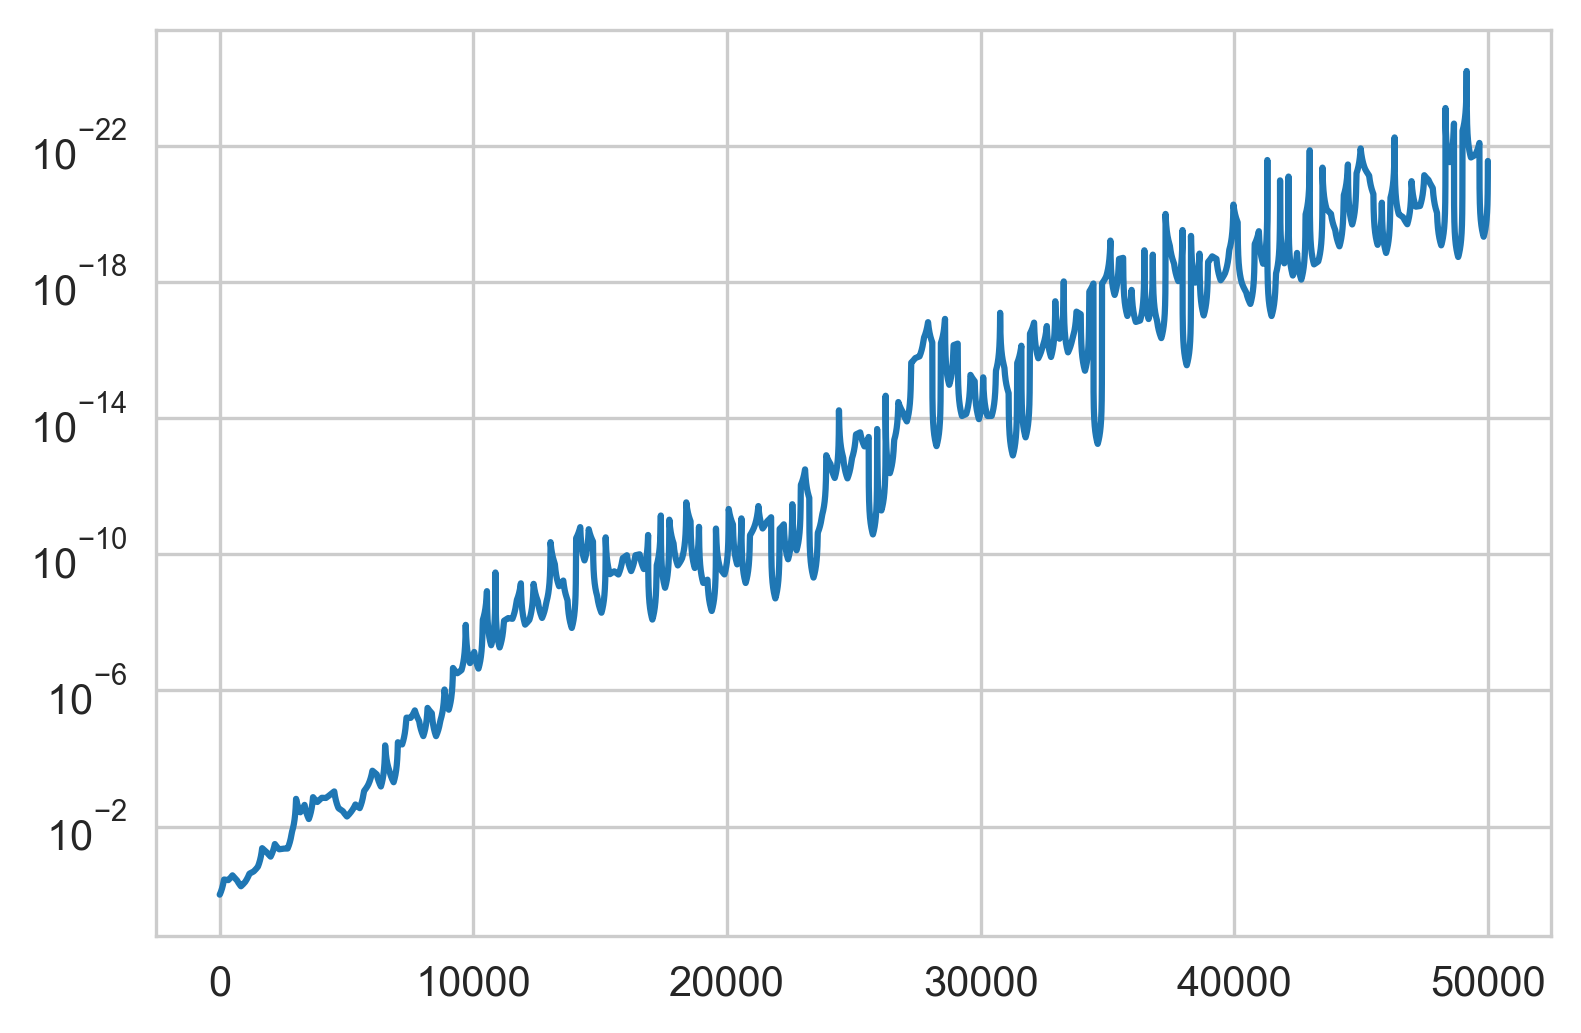

In [99]:
G = sns.lineplot(data=CRI_PG_1)
G.set(yscale='log') #, xlim=(94314,94320))
G.invert_yaxis()

In [100]:
X_ATT_ALL, Y_ATT_ALL = TRACE_SET.attack()
X, Y, X_ATT, Y_ATT = prepare_traces_dl(PROF_X, PROF_Y, X_ATT_ALL[:, WINDOW[0]:WINDOW[1]], Y_ATT_ALL)

0epoch [00:00, ?epoch/s]

/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


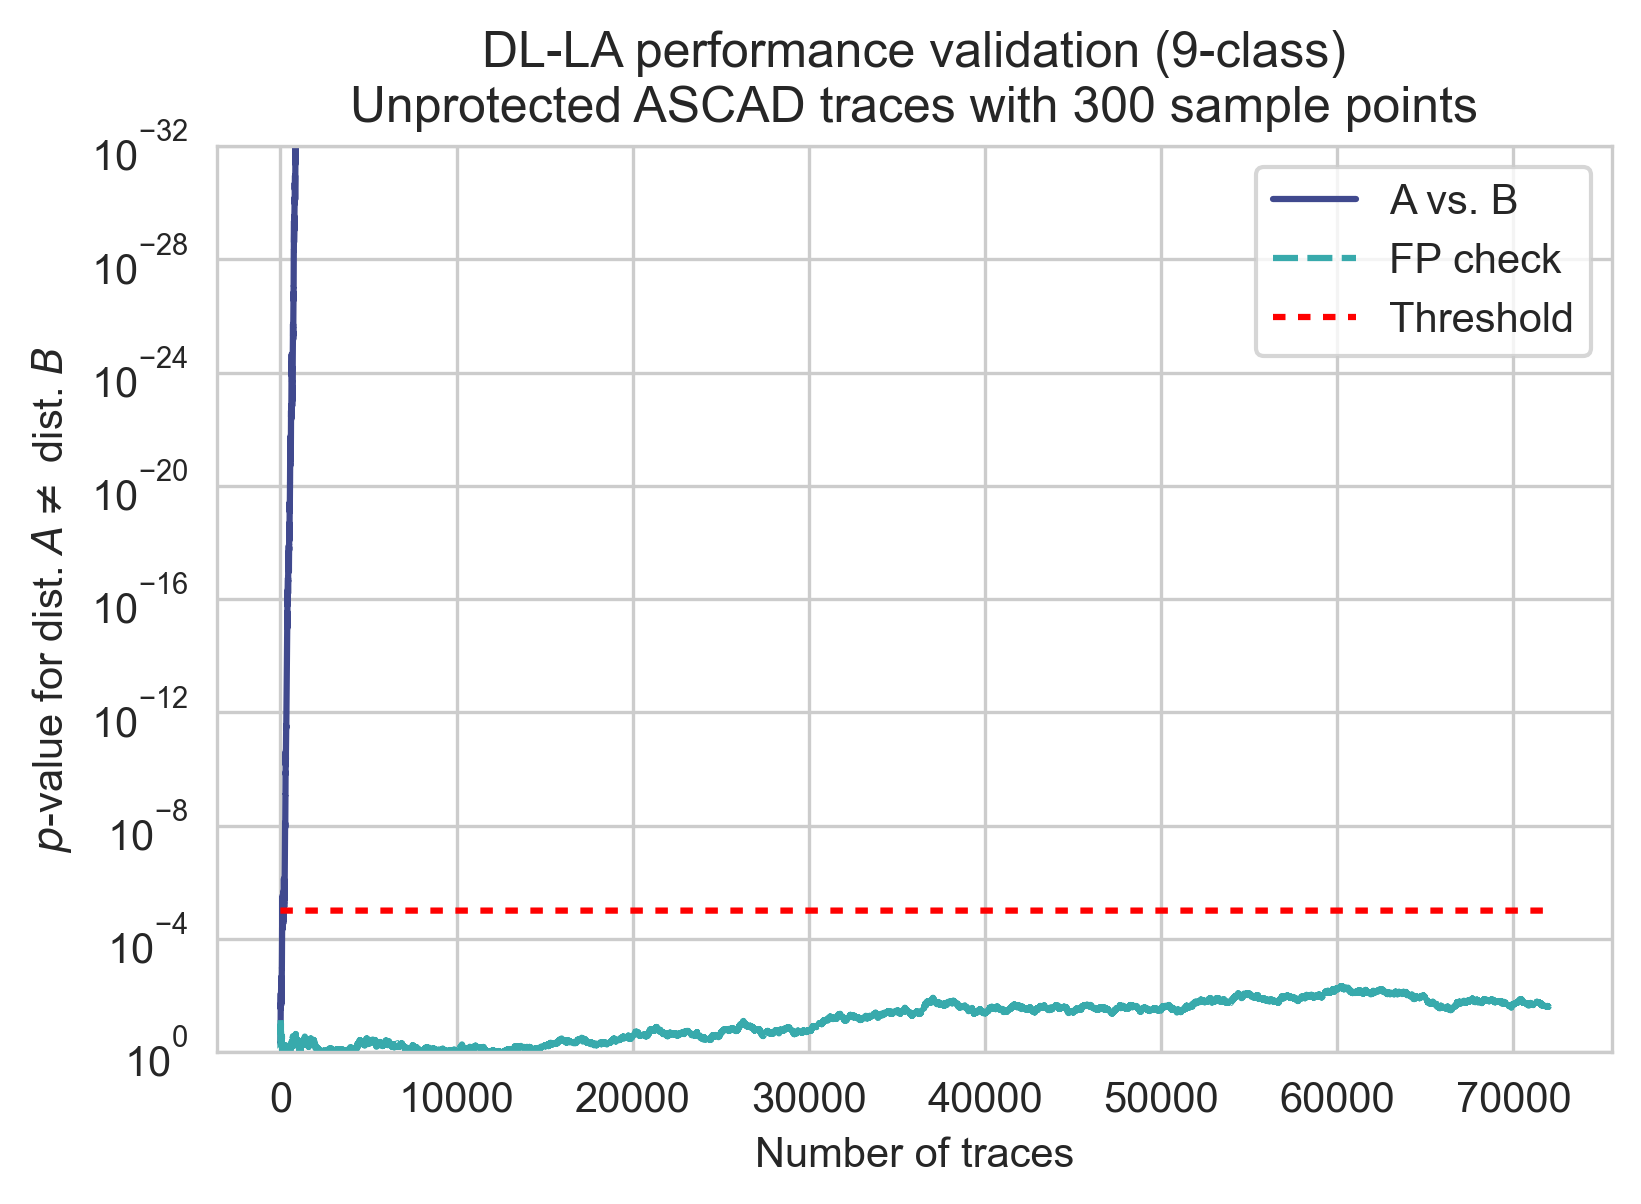

In [101]:
MODEL_9 = make_model_9(X, Y, X_ATT, Y_ATT)
PG_DLLA_9 = dlla_p_gradient(MODEL_9, X_ATT, Y_ATT)
PG_DLLA_9_RANDOM = dlla_p_gradient(MODEL_9, X_ATT, randomize(Y_ATT))

plot_p_gradient({
    "A vs. B": np.array(PG_DLLA_9),
    "FP check": np.array(PG_DLLA_9_RANDOM),
}, f"DL-LA performance validation (9-class)\n{TITLE_SUB}",
    palette=PALETTE_GRADIENT,
)

In [102]:
X_PROF_2, Y_PROF_2 = reduce_fixed_fixed(X, Y)
X_ATT_2, Y_ATT_2 = reduce_fixed_fixed(X_ATT, Y_ATT)
Y_ATT_2_RANDOM = randomize(Y_ATT_2)

Epoch 1/5
962/962 [==============================] - 1s 989us/step - loss: 0.2306 - accuracy: 0.6116

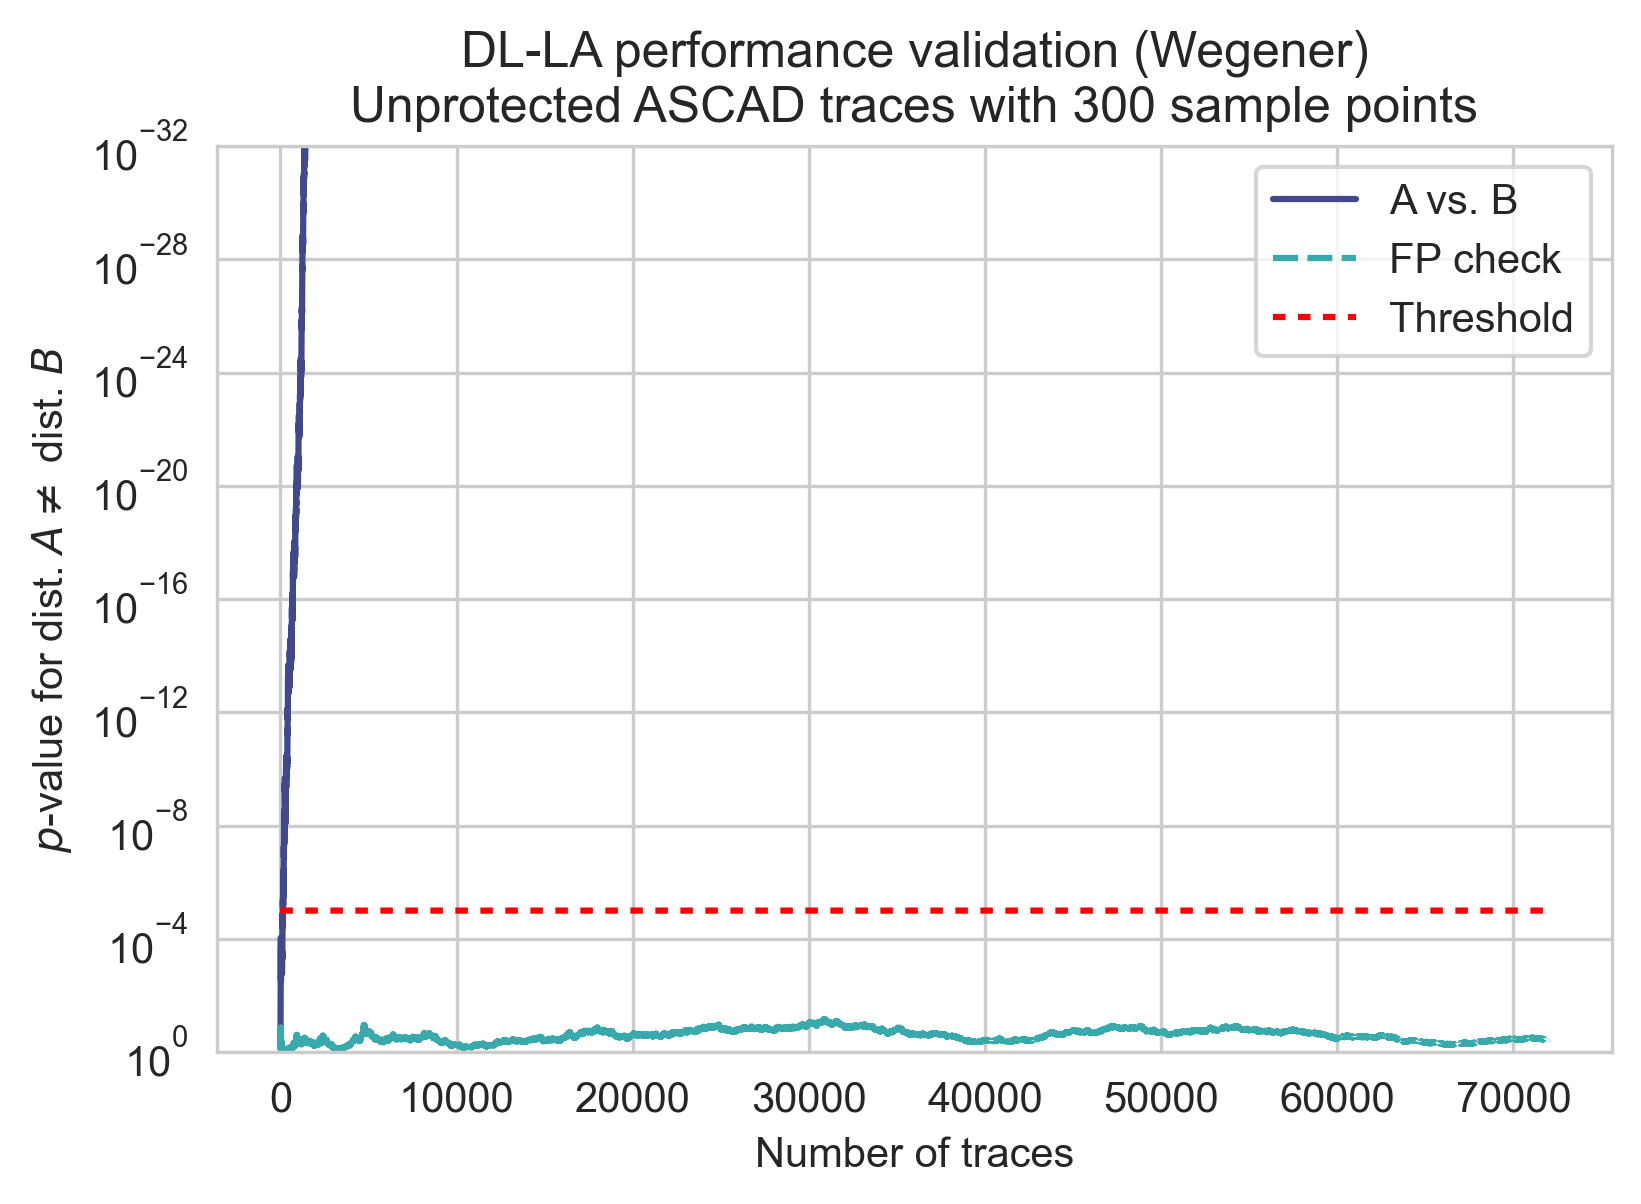

In [103]:
MODEL_WEGENER = make_mlp_wegener(X_PROF_2, Y_PROF_2)

PG_DLLA_2_AB = wegener_p_gradient(MODEL_WEGENER, X_ATT_2, Y_ATT_2)
PG_DLLA_2_RANDOM =  wegener_p_gradient(MODEL_WEGENER, X_ATT_2, Y_ATT_2_RANDOM)

plot_p_gradient({
    "A vs. B": np.array(PG_DLLA_2_AB),
    "FP check": np.array(PG_DLLA_2_RANDOM),
}, f"DL-LA performance validation (Wegener)\n{TITLE_SUB}",
    palette=PALETTE_GRADIENT,
)

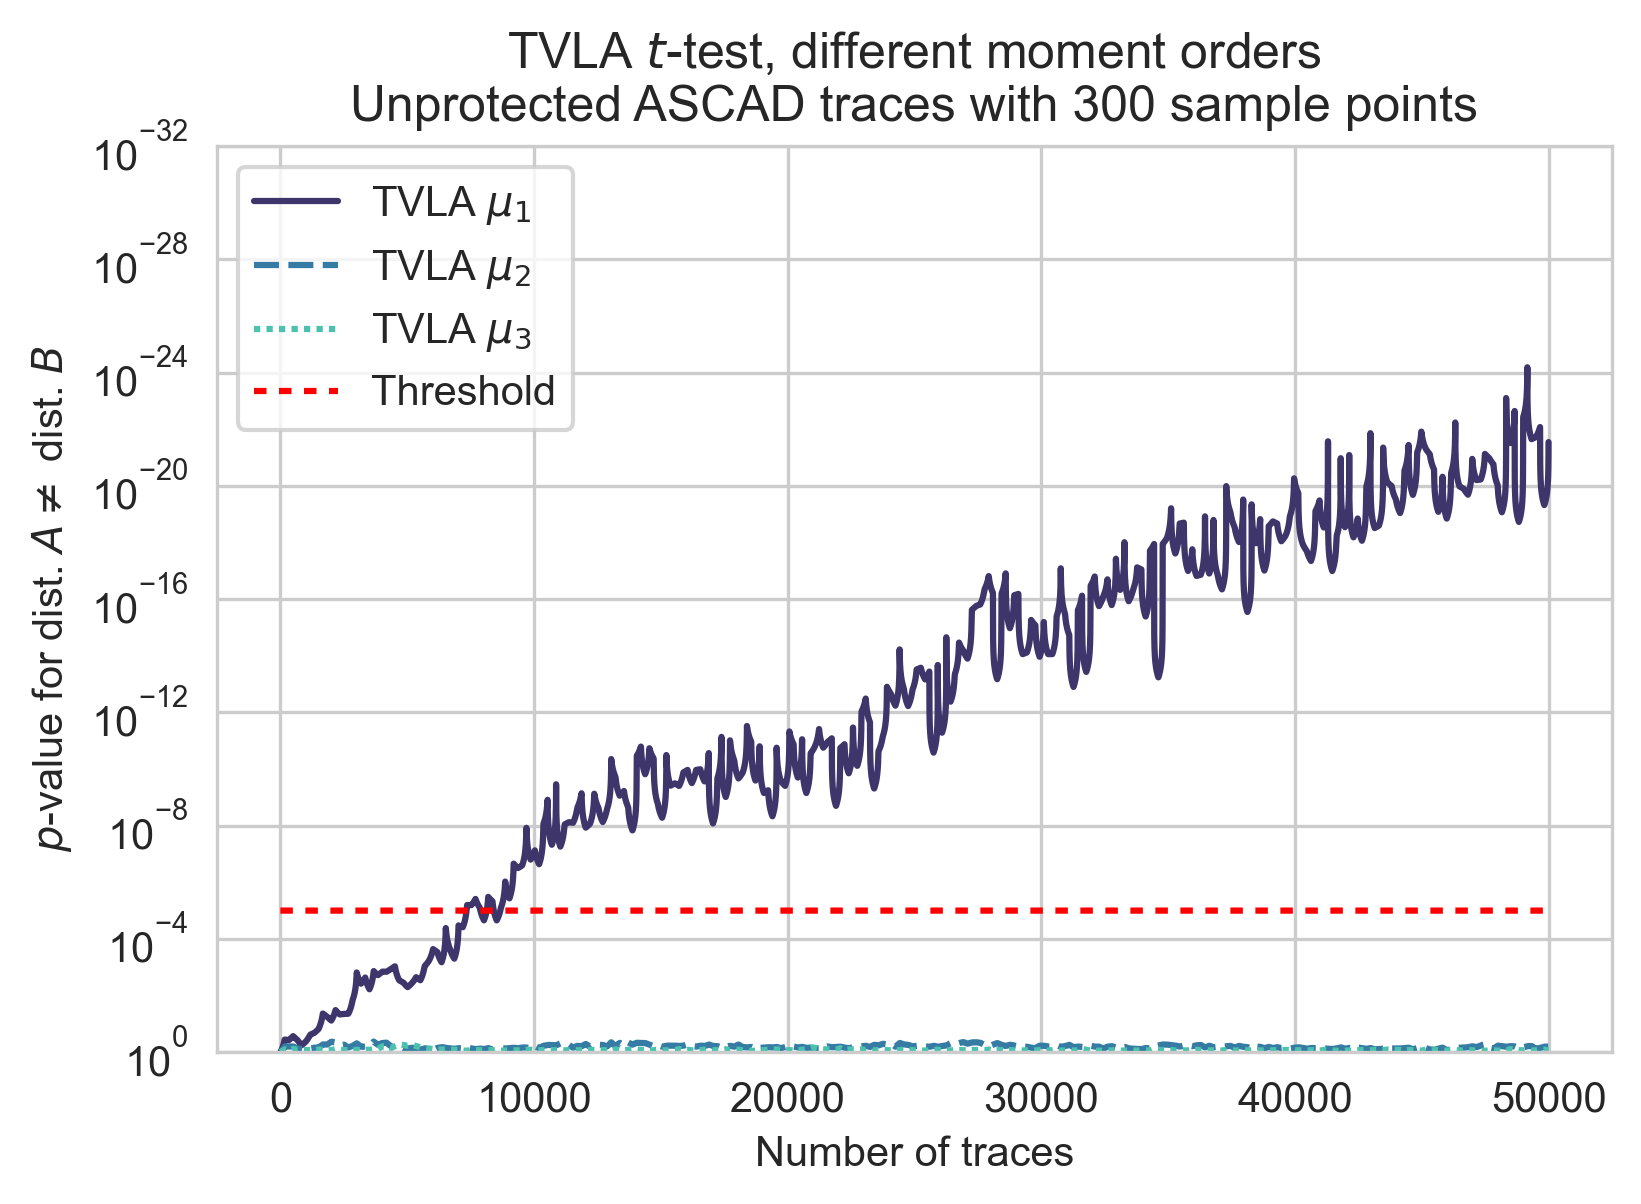

In [104]:
if POLLUTION_TYPE is None:
    TVLA_PGS = {
        "TVLA $\mu_1$": np.array(CRI_PG_1),
        "TVLA $\mu_2$": np.array(CRI_PG_2),
        "TVLA $\mu_3$": np.array(CRI_PG_3),
    }

    plot_p_gradient(TVLA_PGS, f"TVLA $t$-test, different moment orders\n{TITLE_SUB}", palette=PALETTE_GRADIENT, file_name=f"{DB.name}-tvla-orders")

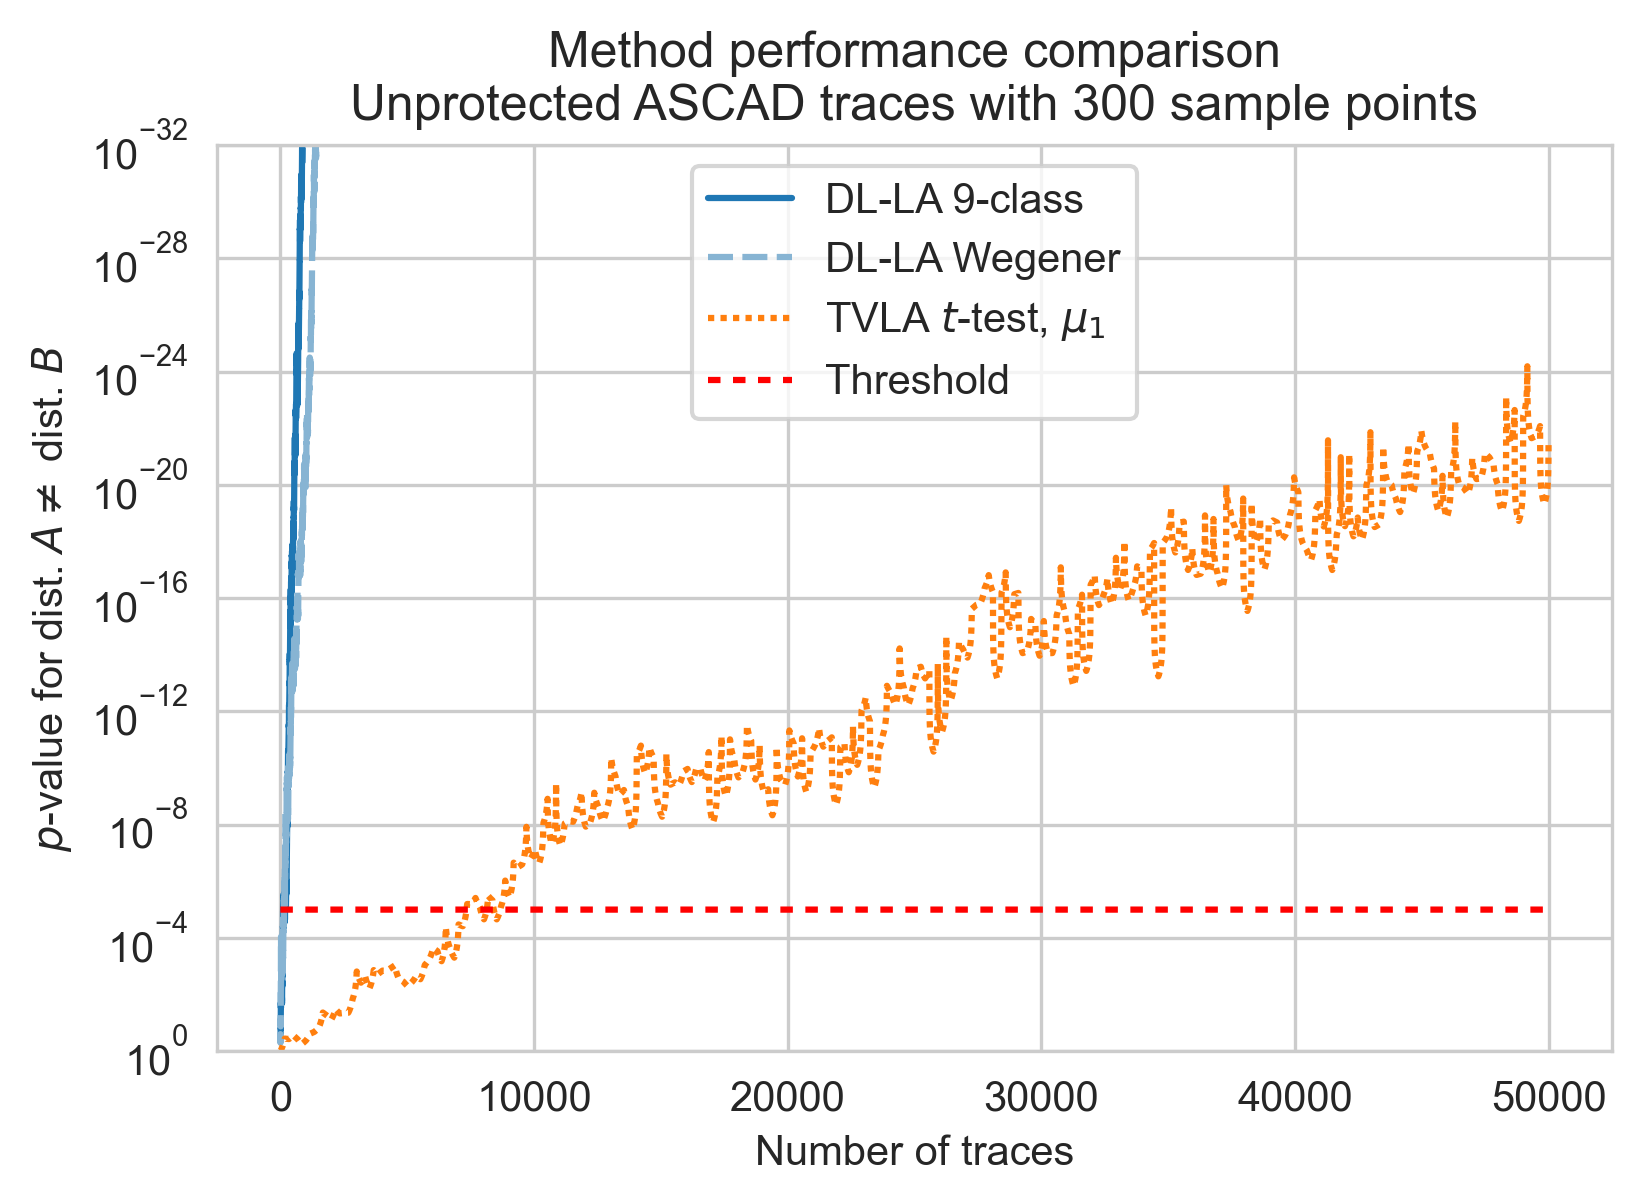

In [105]:
# MAX_TRACE_SIZE = max(len(PG_DLLA_9), len(PG_DLLA_2_AB), len(CRI_PG_2))

COLOR_PALETTE = [DLLA_PALETTE[4], DLLA_PALETTE[2], TVLA_PALETTE[4]]

def expand(arr, max_len=MAX_TRACE_SIZE):
    return np.pad(arr, (0, max(0, max_len - len(arr))), 'constant', constant_values=np.nan)

PGS = {
    "DL-LA 9-class": expand(PG_DLLA_9),
    "DL-LA Wegener": expand(PG_DLLA_2_AB),
    "TVLA $t$-test, $\mu_1$": expand(CRI_PG_1),
}

plot_p_gradient(PGS, f"Method performance comparison\n{TITLE_SUB}", file_name=f"{DB.name}-all{FILE_SUFFIX}", palette=COLOR_PALETTE, max_traces=MAX_TRACE_SIZE)
#
# DF = pd.DataFrame(PGS)
# DF.to_csv(f"{DB.name}-p-gradients{FILE_SUFFIX}.csv")

In [106]:
PGS_CRI_1000_1 = cri_p_gradient(PROF_X, PROF_Y, tvla_cri(*prepare_tvla(PROF_X, PROF_Y), max_order=1, progress=False), 1, trace_limit=1000)
PGS_CRI_1000_2 = cri_p_gradient(PROF_X, PROF_Y, tvla_cri(*prepare_tvla(PROF_X, PROF_Y), max_order=2, progress=False), 2, trace_limit=1000)

CRI p-gradient:   0%|          | 0/20 [00:00<?, ?it/s]/home/berg/Documents/Afstudeer/LA/src/tvla/tvla.py:61: RuntimeWarning: Mean of empty slice.
  self.mean = traces.mean(axis=0)
/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/berg/Documents/Afstudeer/LA/src/tvla/tvla.py:80: RuntimeWarning: invalid value encountered in true_divide
  cm = np.sum(mean_free ** order, axis=0) / self.num_traces
CRI p-gradient: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


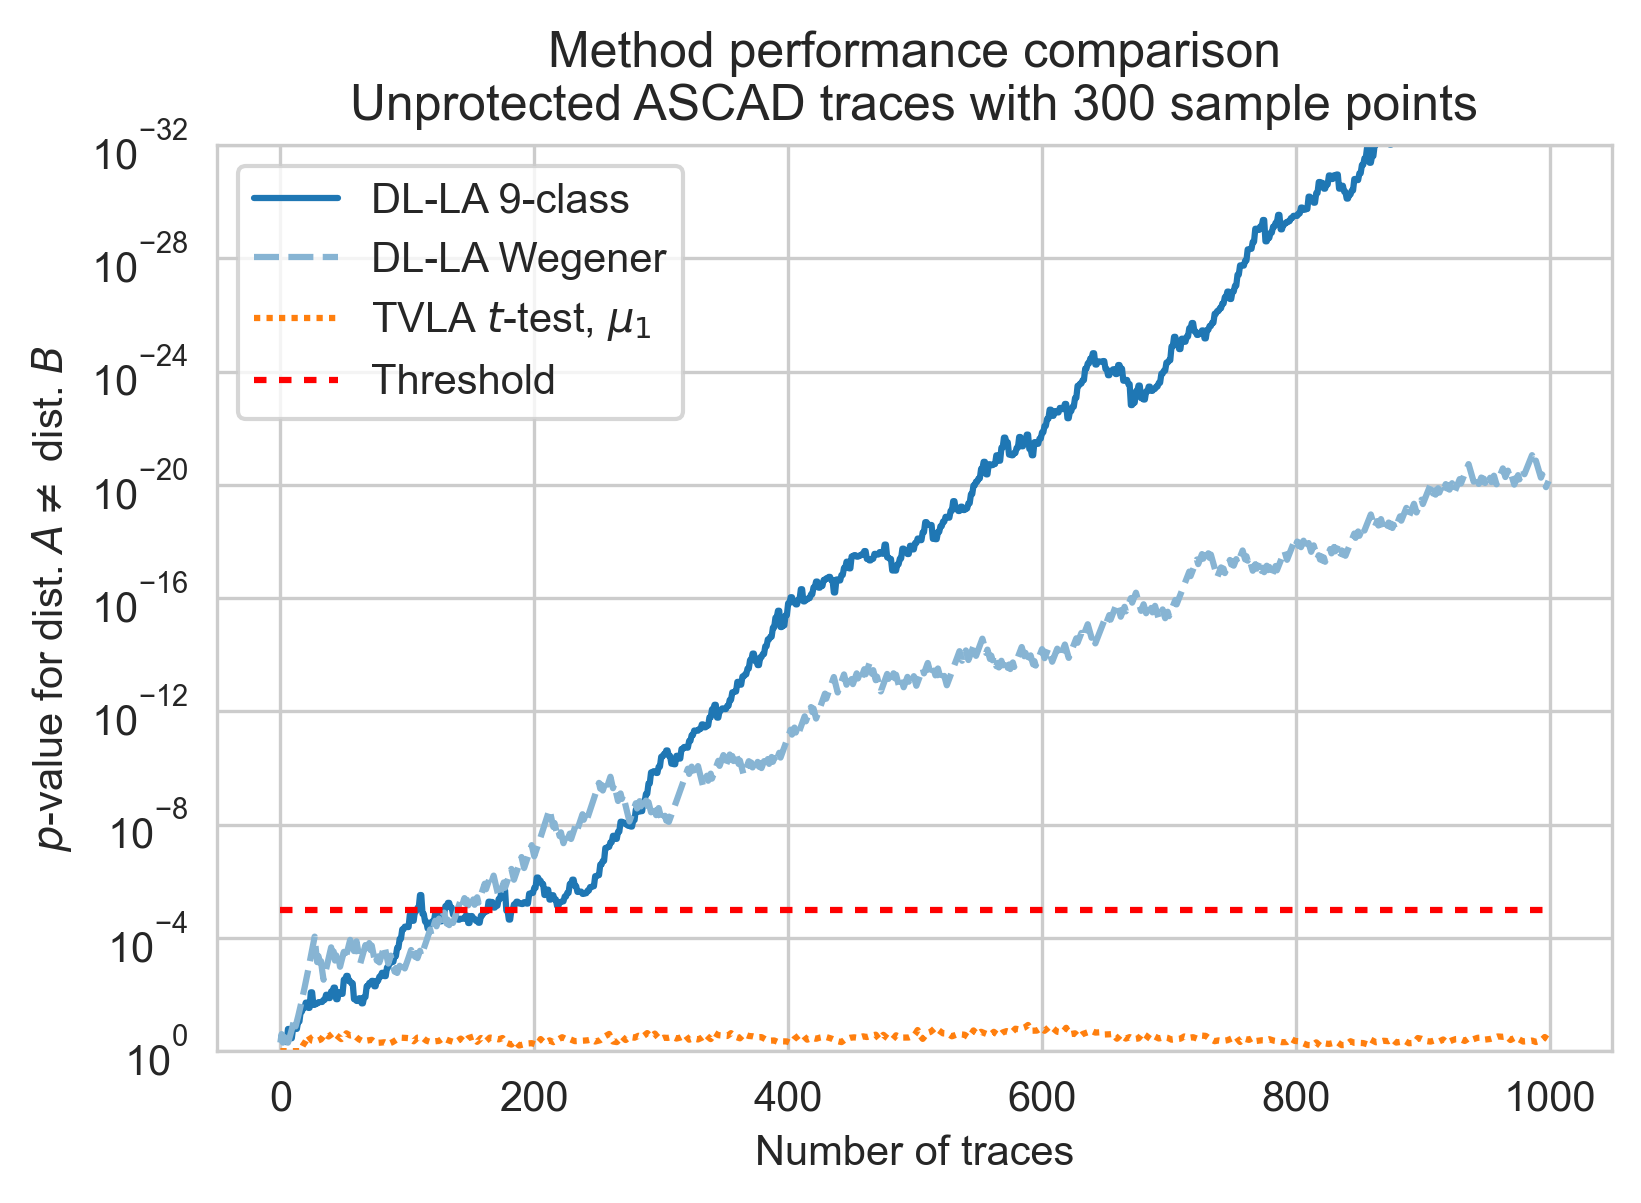

In [107]:
PGS_1000 = {
    "DL-LA 9-class": expand(PG_DLLA_9),
    "DL-LA Wegener": expand(PG_DLLA_2_AB),
    "TVLA $t$-test, $\mu_1$": expand(PGS_CRI_1000_1),
}

plot_p_gradient(PGS_1000, f"Method performance comparison\n{TITLE_SUB}", file_name=f"{DB.name}-all{FILE_SUFFIX}-1000", palette=COLOR_PALETTE, max_traces=1000)

In [108]:
PROF_Y_RANDOM = PROF_Y.copy()
np.random.shuffle(PROF_Y_RANDOM)

PGS_RANDOM_2 = cri_p_gradient(PROF_X, PROF_Y_RANDOM, tvla_cri(*prepare_tvla(PROF_X, PROF_Y_RANDOM), max_order=2, progress=False), 2)

CRI p-gradient:   0%|          | 0/20 [00:00<?, ?it/s]/home/berg/Documents/Afstudeer/LA/src/tvla/tvla.py:61: RuntimeWarning: Mean of empty slice.
  self.mean = traces.mean(axis=0)
/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/berg/Documents/Afstudeer/LA/src/tvla/tvla.py:80: RuntimeWarning: invalid value encountered in true_divide
  cm = np.sum(mean_free ** order, axis=0) / self.num_traces
CRI p-gradient: 100%|██████████| 20/20 [00:42<00:00,  2.10s/it]


In [109]:
# if POLLUTION_TYPE is None:
#     plot_p_gradient({
#         "A vs. B": CRI_PG_2,
#         "Random": PGS_RANDOM_2,
#     }, f"TVLA performance validation ($t$-test for $\\mu_2$)\n{TITLE_SUB}",
#         palette=PALETTE_GRADIENT,
#         file_name=f"{DB.name}-tvla-validation-mu2")